In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
import random
import itertools
import numpy as np

In [2]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA RTX A5500
NVIDIA RTX A5500


In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [4]:
# Define the Shared Encoder (ResNet-18 Backbone)
class SharedEncoder(nn.Module):
    def __init__(self, rotation_model_weights=None):
        super(SharedEncoder, self).__init__()
        self.backbone = resnet18(weights=None)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove the final classification layer

        # Load rotation weights if provided
        if rotation_model_weights:
            state_dict = torch.load(rotation_model_weights)
            self.backbone.load_state_dict(state_dict, strict=False)
            print("Loaded rotation model weights into the shared encoder.")

    def forward(self, x):
        return self.backbone(x)

In [5]:
# Define the Jigsaw Head
class JigsawHead(nn.Module):
    def __init__(self, num_patches, num_permutations):
        super(JigsawHead, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512 * num_patches, 1024),  # Feature size * number of patches
            nn.ReLU(),
            nn.Linear(1024, num_permutations)
        )
    
    def forward(self, x):
        return self.fc(x)

In [6]:
# Combined Model with Shared Encoder and Jigsaw Head
class RotationJigsawModel(nn.Module):
    def __init__(self, num_patches, num_permutations, rotation_model_weights=None):
        super(RotationJigsawModel, self).__init__()
        
        # Shared Encoder with pre-trained rotation weights
        self.backbone = SharedEncoder(rotation_model_weights)
        
        # Jigsaw Task-Specific Head
        self.jigsaw_head = JigsawHead(num_patches=num_patches, num_permutations=num_permutations)

    def forward(self, x):
        batch_size, num_patches, channels, height, width = x.shape
        patches = []
        
        # Process each patch independently through the shared encoder
        for i in range(num_patches):
            patch_features = self.backbone(x[:, i])  # Extract features for each patch
            patch_features = torch.flatten(patch_features, start_dim=1)  # Flatten each patch's features
            patches.append(patch_features)
        
        # Concatenate features from all patches
        concatenated_features = torch.cat(patches, dim=1)  # Shape: [batch_size, 512 * num_patches]
        
        # Forward pass through the jigsaw head
        output = self.jigsaw_head(concatenated_features)
        return output

# Dataset Setup for STL-10 and Jigsaw Task Data Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4), 
    transforms.RandomGrayscale(p=0.1), 
    transforms.ToTensor(),  
])

In [7]:
# Load STL-10 dataset
train_dataset_full = datasets.STL10(root='./data', split='train+unlabeled', download=True, transform=transform)

# Split into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

Files already downloaded and verified


In [8]:
# Custom Dataset for Jigsaw Task
class JigsawSTL10Dataset(Dataset):
    def __init__(self, dataset, grid_size=3, permutations=None):
        self.dataset = dataset
        self.grid_size = grid_size
        self.permutations = permutations or self.create_permutations()

    def create_permutations(self, num_patches=9, num_permutations=1000):
        import itertools
        import random
        all_permutations = list(itertools.permutations(range(num_patches)))
        random.seed(42)  # For reproducibility
        selected_permutations = random.sample(all_permutations, num_permutations)
        return selected_permutations

    def create_jigsaw_puzzle(self, image):
        _, height, width = image.shape
        patch_h, patch_w = height // self.grid_size, width // self.grid_size
        patches = []

        # Extract patches
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                patch = image[:, i * patch_h: (i + 1) * patch_h, j * patch_w: (j + 1) * patch_w]
                patches.append(patch)

        # Select random permutation
        perm_class = random.choice(range(len(self.permutations)))
        perm = self.permutations[perm_class]

        # Shuffle patches based on permutation
        shuffled_patches = [patches[i] for i in perm]
        return torch.stack(shuffled_patches), torch.tensor(perm_class, dtype=torch.long)

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        shuffled_patches, perm_class = self.create_jigsaw_puzzle(img)
        return shuffled_patches, perm_class

    def __len__(self):
        return len(self.dataset)

# Initialize datasets for the Jigsaw Task
jigsaw_train_dataset = JigsawSTL10Dataset(train_dataset)
jigsaw_val_dataset = JigsawSTL10Dataset(val_dataset)

# DataLoaders
jigsaw_train_loader = DataLoader(jigsaw_train_dataset, batch_size=64, shuffle=True, num_workers=8)
jigsaw_val_loader = DataLoader(jigsaw_val_dataset, batch_size=64, shuffle=False, num_workers=8)

# Hyperparameters and Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_patches = 9  # 3x3 grid
num_permutations = 1000  # Number of jigsaw permutations
rotation_weights_path = 'model_weights/rotation_pretext_cross_entropy_model.pth'  # Update with actual path

/tmp/ipykernel_891521/510699227.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(rotation_model_weights)


Loaded rotation model weights into the shared encoder.
Epoch [1/100], Training Loss: 6.9140
Epoch [1/100], Validation Loss: 6.9076
Model saved at Epoch 1
Epoch [2/100], Training Loss: 6.3134
Epoch [2/100], Validation Loss: 4.9843
Model saved at Epoch 2
Epoch [3/100], Training Loss: 4.4838
Epoch [3/100], Validation Loss: 4.0297
Model saved at Epoch 3
Epoch [4/100], Training Loss: 3.8839
Epoch [4/100], Validation Loss: 3.7030
Model saved at Epoch 4
Epoch [5/100], Training Loss: 3.6275
Epoch [5/100], Validation Loss: 3.5266
Model saved at Epoch 5
Epoch [6/100], Training Loss: 3.4703
Epoch [6/100], Validation Loss: 3.4163
Model saved at Epoch 6
Epoch [7/100], Training Loss: 3.3568
Epoch [7/100], Validation Loss: 3.2779
Model saved at Epoch 7
Epoch [8/100], Training Loss: 3.2408
Epoch [8/100], Validation Loss: 3.1697
Model saved at Epoch 8
Epoch [9/100], Training Loss: 3.0745
Epoch [9/100], Validation Loss: 2.9954
Model saved at Epoch 9
Epoch [10/100], Training Loss: 2.8123
Epoch [10/100], 

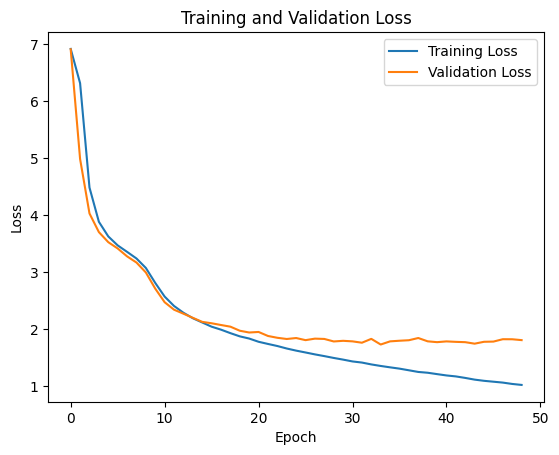

In [9]:
import os
import matplotlib.pyplot as plt

# Initialize the model with rotation weights
model = RotationJigsawModel(num_patches=num_patches, num_permutations=num_permutations, rotation_model_weights=rotation_weights_path).to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Directory to save the best model
checkpoint_dir = './model_weights'
os.makedirs(checkpoint_dir, exist_ok=True)

# Early stopping parameters
early_stopping_patience = 15
best_val_loss = float('inf')
no_improve_epochs = 0

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop for Jigsaw Task
epochs = 100  # Adjust based on your requirements
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for batch_idx, (shuffled_patches, perm_class) in enumerate(jigsaw_train_loader):
        shuffled_patches, perm_class = shuffled_patches.to(device), perm_class.to(device)

        optimizer.zero_grad()
        outputs = model(shuffled_patches)
        loss = criterion(outputs, perm_class)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = running_loss / len(jigsaw_train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_patches, val_perm_class in jigsaw_val_loader:
            val_patches, val_perm_class = val_patches.to(device), val_perm_class.to(device)
            val_outputs = model(val_patches)
            val_loss += criterion(val_outputs, val_perm_class).item()

    avg_val_loss = val_loss / len(jigsaw_val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

    # Model checkpointing based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_path = os.path.join(checkpoint_dir, 'rotation_jigsaw_trained_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, model_path)
        print(f"Model saved at Epoch {epoch+1}")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    # Early stopping based on validation loss
    if no_improve_epochs >= early_stopping_patience:
        print("Early stopping due to no improvement in validation loss.")
        break

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# ResNet Classifier for STL-10 (Downstream Task)
class ResNetClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes=10):
        super(ResNetClassifier, self).__init__()
        self.backbone = pretrained_model.module.backbone if isinstance(pretrained_model, nn.DataParallel) else pretrained_model.backbone # Use the backbone from the pre-trained jigsaw model
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten feature map
        x = self.fc(x)
        return x

# Load the pre-trained jigsaw model
classification_model = ResNetClassifier(model, num_classes=10).to(device)

if torch.cuda.device_count() > 1:
    classification_model = nn.DataParallel(classification_model)

backbone = classification_model.module.backbone if isinstance(classification_model, nn.DataParallel) else classification_model.backbone
    
# Freeze the backbone for fine-tuning
for param in backbone.parameters():
    param.requires_grad = False

In [12]:
# CIFAR-10 DataLoader for classification task
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
classification_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)
classification_test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
# Fine-tuning loop
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

classification_epochs = 150
best_val_loss = float('inf')
early_stopping_patience = 10
no_improve_epochs = 0

for epoch in range(classification_epochs):
    classification_model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(classification_train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        classification_optimizer.zero_grad()
        outputs = classification_model(inputs)
        loss = classification_criterion(outputs, targets)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(classification_train_loader)
    print(f"Epoch [{epoch+1}/{classification_epochs}], Loss: {avg_loss:.4f}")

    # Model checkpointing based on validation loss (use validation loader if needed)
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(classification_model.state_dict(), 'stl_rotation_jigsaw_model.pth')
        print(f"Classification model saved at Epoch {epoch+1}")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    # Early stopping
    if no_improve_epochs >= early_stopping_patience:
        print("Early stopping")
        break

# Evaluation with Top-1 and Top-5 Accuracy
classification_model.eval()
correct = 0
top_5_correct = 0
top_3_correct = 0
total = 0

with torch.no_grad():
    for images, labels in classification_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classification_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Top-5 accuracy
        _, predicted_5 = torch.topk(outputs.data, k=5, dim=1)
        top_5_correct += (predicted_5 == labels.view(-1, 1)).sum().item()

        # Top-3 accuracy
        _, predicted_3 = torch.topk(outputs.data, k=3, dim=1)
        correct_3 = predicted_3.eq(labels.unsqueeze(1).expand_as(predicted_3))
        top_3_correct += correct_3.any(dim=1).sum().item()
       

accuracy = 100 * correct / total
top_5_accuracy = 100 * top_5_correct / total
top_3 = 100 * top_3_correct / total

print(f'Top-1 Accuracy: {accuracy:.2f}%')
print(f'Top-3 Accuracy: {top_3:.2f}%')
print(f'Top-5 Accuracy: {top_5_accuracy:.2f}%')

Epoch [1/150], Loss: 1.0165
Classification model saved at Epoch 1
Epoch [2/150], Loss: 0.9935
Classification model saved at Epoch 2
Epoch [3/150], Loss: 0.9694
Classification model saved at Epoch 3
Epoch [4/150], Loss: 0.9893
Epoch [5/150], Loss: 0.9944
Epoch [6/150], Loss: 1.0197
Epoch [7/150], Loss: 0.9668
Classification model saved at Epoch 7
Epoch [8/150], Loss: 0.9890
Epoch [9/150], Loss: 1.0016
Epoch [10/150], Loss: 0.9870
Epoch [11/150], Loss: 0.9542
Classification model saved at Epoch 11
Epoch [12/150], Loss: 0.9587
Epoch [13/150], Loss: 0.9787
Epoch [14/150], Loss: 0.9452
Classification model saved at Epoch 14
Epoch [15/150], Loss: 0.9588
Epoch [16/150], Loss: 0.9428
Classification model saved at Epoch 16
Epoch [17/150], Loss: 0.9827
Epoch [18/150], Loss: 0.9731
Epoch [19/150], Loss: 0.9948
Epoch [20/150], Loss: 0.9799
Epoch [21/150], Loss: 0.9681
Epoch [22/150], Loss: 0.9696
Epoch [23/150], Loss: 0.9402
Classification model saved at Epoch 23
Epoch [24/150], Loss: 0.9549
Epoch